In [19]:
import matplotlib.pyplot as plt

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import DroneData
from mavlink.mavlink.data import Attitude, GlobalPosition, Quaternion, Gimbal


def get_objects(data):
    quaternion = Quaternion(data['gimbal']['quaternion'])
    
    gimbal = Gimbal(
        timestamp=data['gimbal']['timestamp'],
        flags=data['gimbal']['flags'],
        quaternion=quaternion
    )
    
    global_position = GlobalPosition(
        timestamp=data['global_position']['timestamp'],
        latitude=data['global_position']['latitude'],
        longitude=data['global_position']['longitude'],
        altitude=data['global_position']['altitude'],
        relative_altitude=data['global_position']['relative_altitude'],
        vx=data['global_position']['vx'],
        vy=data['global_position']['vy'],
        vz=data['global_position']['vz'],
        heading=data['global_position']['heading']
    )

    attitude = Attitude(
        timestamp=data['attitude']['timestamp'],
        roll=data['attitude']['roll'],
        pitch=data['attitude']['pitch'],
        yaw=data['attitude']['yaw'],
        roll_speed=data['attitude']['roll_speed'],
        pitch_speed=data['attitude']['pitch_speed'],
        yaw_speed=data['attitude']['yaw_speed']
    )

    all_objects = {
        "gimbal": gimbal,
        "global_position": global_position,
        "attitude": attitude,
        "webots": DroneData.from_json(data['webots_data'])
    }
    
    return all_objects

In [20]:
import json

file_name = "data.json"

with open(file_name, "r") as file:
    data = json.load(file)

In [21]:
from ultralytics import YOLO


model = YOLO("yolov8n-visdrone.pt", verbose=False)

In [22]:
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=False
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

In [23]:
import pandas

dataframe = pandas.read_csv("detections.csv")

detections_by_frame = {}

grouped = dataframe.groupby("frame")

for frame_number, group in grouped:
    detections = [
        [int(x1), int(y1), int(x2), int(y2), score, int(cls)]
        for x1, y1, x2, y2, score, cls in group[['x1', 'y1', 'x2', 'y2', 'score', 'class']].values
    ]
    detections_by_frame[str(frame_number)] = detections

In [ ]:
import cv2
from tqdm import tqdm


tracker = Tracker(
    feature_extractor=extractor
)

progress_bar = tqdm(total=len(data))

for key, value in data.items():
    frame = get_objects(value)["webots"].camera.frame
    
    detections = detections_by_frame.get(key, [])
    
    tracker.update(frame, detections)
    
    for track in tracker.tracks:
        x1, y1, x2, y2 = track.to_tlbr()
        track_id = track.track_id
        class_id = track.class_id
        
        color = colors[track_id % len(colors)]
    
        cv2.rectangle(
            frame,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color,
            3
        )
    
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
    
        cv2.circle(
            frame,
            (cx, cy),
            3,
            color,
            -1
        )
    
        cv2.putText(
            frame,
            f"ID: {track_id}",
            (cx + 10, cy),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2
        )
    
    out.write(frame)
    
    progress_bar.update(1)
    
out.release()

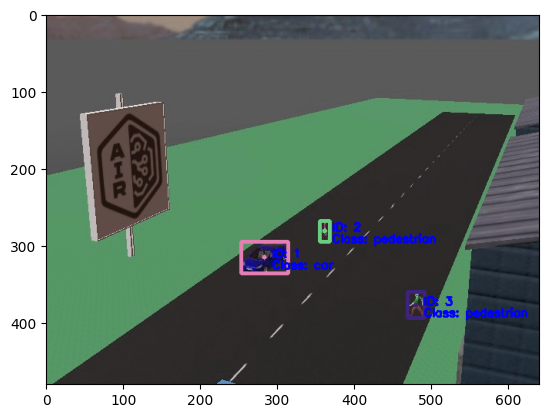

In [24]:
import cv2


colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

tracker = Tracker(
    feature_extractor=extractor
)

frame_key = "536"

for _ in range(10):
    frame = get_objects(data[frame_key])["webots"].camera.frame
    detections = detections_by_frame.get(frame_key, [])
    
    tracker.update(frame, detections)
    
    for track in tracker.tracks:
        x1, y1, x2, y2 = map(int, track.to_tlbr())
        
        color = colors[track.track_id % len(colors)]
    
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
    
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
    
        cv2.circle(frame, (cx, cy), 3, color, -1)
    
        cv2.putText(
            frame,
            f"ID: {track.track_id}",
            (cx + 10, cy),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2
        )
        
        cv2.putText(
            frame,
            f"Class: {model.names[track.class_id]}",
            (cx + 10, cy + 15),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2
        )
        
plt.imshow(frame)
# cv2.imwrite("deep_sort_tracks.png", frame)

In [43]:
for i in range(450, 550):
    frame_key = str(i)
    
    frame = get_objects(data[frame_key])["webots"].camera.frame
    detections = detections_by_frame.get(frame_key, [])
        
    if len(detections) == 3:                    
        class_list = [class_id[-1] for class_id in detections]
        # print(class_list)
        target = [0, 0, 3]

        if sorted(class_list) == sorted(target):
            print(i, detections)

536 [[253, 295, 314, 336, 0.9233328104019164, 3], [355, 268, 368, 295, 0.3714068830013275, 0], [469, 360, 491, 394, 0.3664138913154602, 0]]
544 [[253, 295, 314, 336, 0.922832489013672, 3], [359, 265, 374, 294, 0.5561919212341309, 0], [461, 361, 488, 397, 0.5309656858444214, 0]]
547 [[253, 295, 314, 336, 0.9201354384422302, 3], [458, 360, 488, 399, 0.8353871703147888, 0], [363, 267, 376, 295, 0.6808608174324036, 0]]
548 [[253, 295, 314, 336, 0.9208929538726808, 3], [460, 360, 487, 399, 0.7827515006065369, 0], [363, 265, 376, 296, 0.6071218848228455, 0]]
549 [[253, 295, 314, 336, 0.9253760576248168, 3], [363, 266, 377, 296, 0.7711309790611267, 0], [458, 360, 485, 400, 0.6766265630722046, 0]]


In [42]:
print(model.names)

{0: 'pedestrian', 1: 'people', 2: 'bicycle', 3: 'car', 4: 'van', 5: 'truck', 6: 'tricycle', 7: 'awning-tricycle', 8: 'bus', 9: 'motor'}


In [29]:
tracks = []

for track in tracker.tracks:   
    tracks.append([*track.to_tlbr()] + [track.track_id] + [track.class_id])
    
print(tracks)

[[253.0, 295.0, 314.0, 336.0, 1, 3], [355.0, 268.0, 368.0, 295.0, 2, 0], [469.0, 360.0, 491.0, 394.0, 3, 0]]


In [6]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import transform
import math
import numpy


def find_elevation(latitude, longitude, file_path="S36E149.hgt"):
    with rasterio.open(file_path) as src:
        transformed_point = transform(
            {'init': 'epsg:4326'},
            src.crs,
            [longitude], [latitude]
        )
        
        row, col = src.index(transformed_point[0][0], transformed_point[1][0])
        elevation = src.read(1, window=rasterio.windows.Window(col, row, 1, 1), resampling=Resampling.nearest)
        
        return elevation[0][0]


def find_target_location(global_position, gimbal, offset=None):    
    roll, pitch, yaw = gimbal.quaternion.to_euler()
    heading = math.radians(global_position.heading)  
    yaw = yaw + heading
    
    if offset:
        offset_roll, offset_pitch, offset_yaw = offset
        
        roll += offset_roll
        pitch += offset_pitch
        yaw += offset_yaw
    
    direction_vector = numpy.array([
        math.cos(pitch) * math.sin(yaw),
        math.cos(pitch) * math.cos(yaw),
        math.sin(pitch)
    ])
    
    distance_to_ground = global_position.relative_altitude / -direction_vector[2]
    
    target_enu = direction_vector * distance_to_ground
    
    earth_radius = 6371000
    latitude_change = target_enu[1] / earth_radius
    longitude_change = target_enu[0] / (earth_radius * math.cos(math.radians(global_position.latitude)))
    
    target_latitude = global_position.latitude + math.degrees(latitude_change)
    target_longitude = global_position.longitude + math.degrees(longitude_change)
    target_altitude = find_elevation(target_latitude, target_longitude)
    
    return target_latitude, target_longitude, target_altitude


def distance_between_locations(lat1, lon1, alt1, lat2, lon2, alt2):
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    lambda1, lambda2 = math.radians(lon1), math.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    delta_alt = alt2 - alt1
    
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    earth_radius = 6371000
    distance = earth_radius * c
    
    total_distance = math.sqrt(distance ** 2 + delta_alt ** 2)
    
    return total_distance


In [25]:
drone_data = get_objects(data[frame_key])

print(drone_data["gimbal"].quaternion.to_euler())
print(drone_data["attitude"])
print(drone_data["global_position"])

(0.0, -0.2617994102232619, 0.0)
Attitude(timestamp=1715521894.6404138, roll=0.00024251312424894422, pitch=-0.0001344618503935635, yaw=-0.49684950709342957, roll_speed=0.002670224290341139, pitch_speed=0.0032338600140064955, yaw_speed=0.003578301751986146)
GlobalPosition(timestamp=1715521894.6511507, latitude=-35.3634496, longitude=149.1653888, altitude=601.01, relative_altitude=16.94, vx=0.0, vy=0.0, vz=0.0, heading=331.54)


In [120]:
gimbal_roll, gimbal_pitch, gimbal_yaw = drone_data["gimbal"].quaternion.to_euler()
drone_roll = math.radians(drone_data["attitude"].roll)
drone_pitch = math.radians(drone_data["attitude"].pitch) 
drone_yaw = math.radians(drone_data["global_position"].heading)

view_roll = gimbal_roll + drone_roll
view_pitch = gimbal_pitch + drone_pitch
view_yaw = gimbal_yaw + drone_yaw

drone_position = drone_data["global_position"]

print(drone_position)
print([math.degrees(ang) for ang in [view_roll, view_pitch, view_yaw]])

GlobalPosition(timestamp=1715521894.6511507, latitude=-35.3634496, longitude=149.1653888, altitude=601.01, relative_altitude=16.94, vx=0.0, vy=0.0, vz=0.0, heading=331.54)
[0.00024251312424894425, -15.000135746657397, 331.54]


In [111]:
camera_data = drone_data["webots"].camera

image_width = camera_data.width
image_height = camera_data.height

fov_horizontal = camera_data.fov
fov_vertical = 2 * math.atan(math.tan(fov_horizontal / 2) * (image_height / image_width))


In [176]:
def detection_angles(target_location, image_size, fov_horizontal, fov_vertical):
    x, y = target_location
    width, height = image_size
    theta_x = (x - width / 2) * fov_horizontal / width
    theta_y = (y - height / 2) * fov_vertical / height
    
    return theta_x, theta_y

def find_center(x1, y1, x2, y2):
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    
    return center_x, center_y

def calculate_direction_vector(view_angles, detection_offset):
    view_roll, view_pitch, view_yaw = view_angles
    theta_x, theta_y = detection_offset
    
    final_roll = view_roll
    final_pitch = view_pitch - theta_y
    final_yaw = view_yaw + theta_x
    
    direction_vector = numpy.array([
        math.cos(final_pitch) * math.sin(final_yaw),
        math.cos(final_pitch) * math.cos(final_yaw),
        math.sin(final_pitch)
    ])
    
    cos_roll = math.cos(final_roll)
    sin_roll = math.sin(final_roll)
    rotation_matrix = numpy.array([
        [1, 0, 0],
        [0, cos_roll, -sin_roll],
        [0, sin_roll, cos_roll]
    ])
    direction_vector = numpy.dot(rotation_matrix, direction_vector)
    
    return direction_vector
    
    
def find_target_location(drone_position, direction_vector):
    step_size = 1.0
    max_distance = 1000
    
    lat_step = step_size / 111320
    lon_step = step_size / (111320 * math.cos(math.radians(drone_position.latitude)))

    for i in range(1, int(max_distance / step_size)):
        d_lat = direction_vector[1] * lat_step * i
        d_lon = direction_vector[0] * lon_step * i
        d_alt = direction_vector[2] * step_size * i
        
        new_lat = drone_position.latitude + d_lat
        new_lon = drone_position.longitude + d_lon
        new_alt = drone_position.altitude + d_alt
        
        terrain_height = find_elevation(new_lat, new_lon)
                
        if new_alt <= terrain_height:
            return new_lat, new_lon, terrain_height
        
    return None


In [191]:
target_locations = []

for track in tracks:
    x1, y1, x2, y2, target_id, class_id = track

    detection_offset = detection_angles(find_center(x1, y1, x2, y2), (image_width, image_height), fov_horizontal, fov_vertical)
    
    direction_vector = calculate_direction_vector((view_roll, view_pitch, view_yaw), detection_offset)
    
    target_location = find_target_location(drone_position, direction_vector)
    
    target_locations.append([target_id, *target_location])


drone_position

GlobalPosition(timestamp=1715521894.6511507, latitude=-35.3634496, longitude=149.1653888, altitude=601.01, relative_altitude=16.94, vx=0.0, vy=0.0, vz=0.0, heading=331.54)

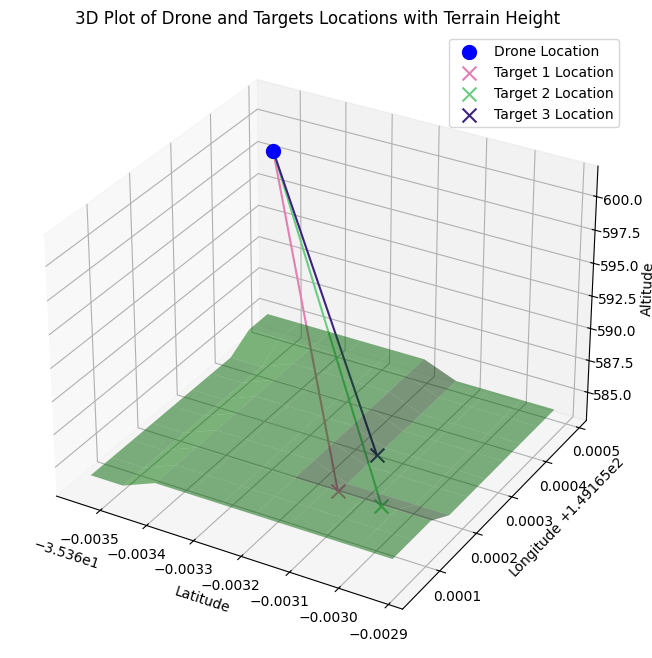

In [216]:
import matplotlib.pyplot as plt


latitudes = [location[1] for location in target_locations] + [drone_position.latitude]
longitudes = [location[2] for location in target_locations] + [drone_position.longitude]

latitude_grid, longitude_grid = numpy.meshgrid(
    numpy.linspace(min(latitudes) - 0.0001, max(latitudes) + 0.0001, 10),
    numpy.linspace(min(longitudes) - 0.0001, max(longitudes) + 0.0001, 10)
)
elevation_grid = numpy.vectorize(find_elevation)(latitude_grid, longitude_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(latitude_grid, longitude_grid, elevation_grid, color="green", alpha=0.5)

ax.scatter(drone_position.latitude, drone_position.longitude, drone_position.altitude, color="blue", s=100, label="Drone Location", marker="o")

for target_location in target_locations:
    target_id, target_latitude, target_longitude, target_altitude = target_location
    color = [channel / 255 for channel in colors[target_id % len(colors)]]
    ax.scatter(target_latitude, target_longitude, target_altitude, color=color, s=100, label=f"Target {target_id} Location", marker="x")

    ax.plot(
        [drone_position.latitude, target_latitude], 
        [drone_position.longitude, target_longitude],
        [drone_position.altitude, target_altitude], 
        color=color, linestyle="-"
    )

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_zlabel("Altitude")
ax.set_title("3D Plot of Drone and Targets Locations with Terrain Height")
ax.legend()

plt.show()

In [217]:
import folium

drone_location = [drone_position.latitude, drone_position.longitude]
folium_map = folium.Map(location=drone_location, zoom_start=18)
folium.Marker(
    location=drone_location,
    popup="Drone Location"
).add_to(folium_map)

for target_location in target_locations:
    target_id, target_latitude, target_longitude, target_altitude = target_location
    color = colors[target_id % len(colors)]
    
    folium.Marker(
        [target_latitude, target_longitude],
        popup=f"Target {target_id} Location",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(folium_map)
    
    folium.PolyLine(
        locations=[
            [drone_position.latitude, drone_position.longitude],
            [target_latitude, target_longitude]
        ],
        weight=4,
        opacity=1
    ).add_to(folium_map)


folium_map